In [6]:
%load_ext autoreload
%autoreload 2

## Get dataset to train

In [7]:
import json
import torch    #if error, restart kernel
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

import glob
import pandas as pd

Fs = 100  # Sampling frequency

# Path to the folder containing the CSV files
folder_path = "TFO Data\\PPG\\Clean PPG"

# Get the list of CSV files in the folder
file_list = glob.glob(folder_path + "\*.csv")
file_path = file_list[0]

# Read the CSV file into a pandas dataframe
df = pd.read_csv(file_path)
#df = df[df.columns[2:-1]]  # Remove the time, index, and temperature columns
    
# Show the head of the dataframe
title = file_path.split("\\")[-1]
print(title)
print(df.shape)
df.head()

HR4.csv
(182480, 10)


,Ch1volts_WL1,Ch2volts_WL1,Ch3volts_WL1,Ch4volts_WL1,Ch5volts_WL1,Ch1volts_WL2,Ch2volts_WL2,Ch3volts_WL2,Ch4volts_WL2,Ch5volts_WL2
0,0.000002,8.812440e-09,7.278859e-10,3.547247e-11,1.230252e-12,4.888189e-07,1.014160e-08,5.066293e-11,1.971175e-12,1.683671e-13
1,0.000002,8.866842e-09,7.359912e-10,3.567527e-11,1.232126e-12,4.941796e-07,1.083115e-08,5.613977e-11,2.132041e-12,1.813407e-13
2,0.000002,8.932950e-09,7.450155e-10,3.590589e-11,1.234843e-12,5.001466e-07,1.155518e-08,6.215791e-11,2.304295e-12,1.951288e-13
3,0.000002,9.013877e-09,7.551500e-10,3.617334e-11,1.238755e-12,5.067280e-07,1.231436e-08,6.875983e-11,2.488521e-12,2.097654e-13
4,0.000002,9.112364e-09,7.665012e-10,3.648827e-11,1.244208e-12,5.138828e-07,1.310927e-08,7.598956e-11,2.685308e-12,2.252847e-13


### Normalize data in dataframe

In [8]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

columns = df.columns
index = df.index

# Normalize the data
scaler = StandardScaler() # Can't use this with BCELoss
#scaler = MinMaxScaler()
df = scaler.fit_transform(df)
df = pd.DataFrame(df, columns=columns, index=index)
df.head()

,Ch1volts_WL1,Ch2volts_WL1,Ch3volts_WL1,Ch4volts_WL1,Ch5volts_WL1,Ch1volts_WL2,Ch2volts_WL2,Ch3volts_WL2,Ch4volts_WL2,Ch5volts_WL2
0,-0.538759,-0.664989,-0.499580,-0.343222,-0.312601,-0.609809,-0.277720,-0.730452,-0.644684,-0.463153
1,-0.482541,-0.659695,-0.485675,-0.325992,-0.306380,-0.589670,-0.244317,-0.723975,-0.631475,-0.439833
2,-0.414578,-0.653261,-0.470194,-0.306398,-0.297368,-0.567252,-0.209244,-0.716858,-0.617330,-0.415049
3,-0.335063,-0.645385,-0.452809,-0.283676,-0.284387,-0.542527,-0.172469,-0.709051,-0.602202,-0.388740
4,-0.245473,-0.635800,-0.433336,-0.256919,-0.266294,-0.515648,-0.133962,-0.700501,-0.586042,-0.360844


In [9]:
x = df['Ch1volts_WL1']
y = df['Ch2volts_WL1']
print(x.shape)
print(y.shape)

(182480,)
(182480,)


## Create model and dataloaders

In [10]:
from Utils.models import VAE
from Utils.dataloader import DataLoaderGenerator
from Utils.processing import window_data

# Window the data
# data = window_data(x, 100)
data_x = window_data(x, 100)
data_y = window_data(y, 100)
# print(f"Data shape: {data.shape}")
print(f"Data shape: {data_x.shape}")
print(f"Data shape: {data_y.shape}")

# Create a DataLoader object
#dataloader = DataLoaderGenerator(data, batch_size=32)
dataloader = DataLoaderGenerator([data_x, data_y], batch_size=32)
#train_loader, val_loader = dataloader.generate()
train_loader = dataloader.generate()
print(f"Number of batches: {len(train_loader)}")

# Initialize the model
vae = VAE(input_dims=100, latent_dims=6)#, device='cpu')


Data shape: (182381, 100)
Data shape: (182381, 100)
Number of batches: 11398


In [11]:
from torchsummary import summary
if torch.cuda.is_available():
    vae = vae.to('cuda')
print(vae)
summary(vae, (1, 100))

VAE(
  (encoder): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(2,), padding=(31,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv1d(32, 64, kernel_size=(3,), stride=(2,), padding=(21,))
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(11,))
    (7): LeakyReLU(negative_slope=0.01)
    (8): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv1d(128, 512, kernel_size=(4,), stride=(2,), padding=(5,))
    (10): LeakyReLU(negative_slope=0.01)
    (11): Flatten(start_dim=1, end_dim=-1)
    (12): Linear(in_features=12288, out_features=24, bias=True)
    (13): LeakyReLU(negative_slope=0.01)
  )
  (decoder): Sequential(
    (0): Linear(in_features=6, out_features=24, bias=True)
    (1): LeakyReLU(negat

## Train Model

In [12]:
train_save = True
if train_save:
    # Train the model
    vae.train_model(train_loader, n_epochs=10)
    # Save the model
    vae.save_model("Weights/vae.pth")
else:
    # Load the model
    vae.load_model("Weights/vae.pth")
    vae.eval()

Epoch 1/10, Loss: 4131.94775390625
Epoch 2/10, Loss: 1531.2784423828125
Epoch 3/10, Loss: 223.1237335205078
Epoch 4/10, Loss: 779.0656127929688
Epoch 5/10, Loss: 791.034423828125
Epoch 6/10, Loss: 554.9790649414062
Epoch 7/10, Loss: 658.4357299804688
Epoch 8/10, Loss: 567.9481811523438
Epoch 9/10, Loss: 550.6943359375
Epoch 10/10, Loss: 896.304443359375


### Loss Analysis

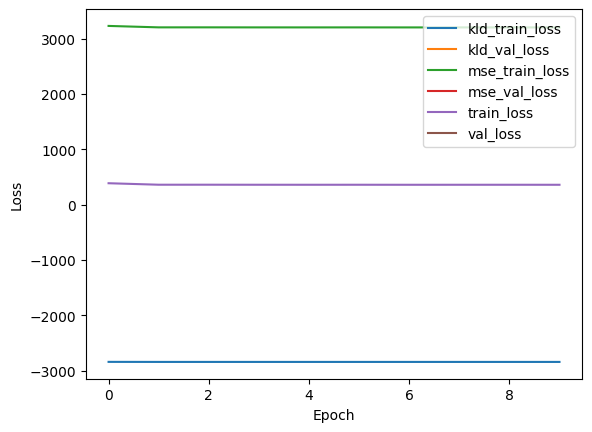

In [8]:
if train_save:
    vae.plot_loss()

## Create LSTM data and model

In [11]:
encoded_training_data = vae.encode_data(train_loader)

In [12]:
print(encoded_training_data.shape)

(110048, 6)


In [13]:
# Create a DataLoader object
lstm_dataloader = DataLoaderGenerator(encoded_training_data, batch_size=32)
#train_loader_lstm, val_loader_lstm = lstm_dataloader.generate()
train_loader_lstm = lstm_dataloader.generate()

In [14]:
train_loader_lstm.dataset.tensors[0].shape

torch.Size([110048, 1, 6])

In [15]:
from Utils.models import LSTM
from torchinfo import summary as summary2

lstm = LSTM()
if torch.cuda.is_available():
    lstm = lstm.to('cuda')
print(lstm)
summary2(lstm, input_size=(1, 6))

LSTM(
  (models): ModuleList(
    (0): LSTM(6, 64, batch_first=True)
    (1): LSTM(64, 64, batch_first=True)
    (2): LSTM(64, 6, batch_first=True)
    (3): Linear(in_features=6, out_features=6, bias=True)
  )
)


Layer (type:depth-idx)                   Output Shape              Param #
LSTM                                     [1, 6]                    --
├─ModuleList: 1-1                        --                        42
│    └─LSTM: 2-1                         [1, 64]                   18,432
│    └─LSTM: 2-2                         [1, 64]                   33,280
│    └─LSTM: 2-3                         [1, 6]                    1,728
Total params: 53,482
Trainable params: 53,482
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 3.32
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.21
Estimated Total Size (MB): 0.21

## Train LSTM

In [17]:
train_save = True
if train_save:
    # Train the model
    lstm.train_model(train_loader_lstm, n_epochs=10)
    # Save the model
    lstm.save_model("Weights/lstm.pth")
else:
    # Load the model
    lstm.load_model("Weights/lstm.pth")
    lstm.eval()

Epoch 1/10, Loss: 38.76661682128906
Epoch 2/10, Loss: 47.334251403808594
Epoch 3/10, Loss: 53.1032829284668
Epoch 4/10, Loss: 51.886802673339844
Epoch 5/10, Loss: 52.67978286743164
Epoch 6/10, Loss: 44.86387634277344
Epoch 7/10, Loss: 56.80243682861328
Epoch 8/10, Loss: 56.61362075805664
Epoch 9/10, Loss: 49.10042953491211
Epoch 10/10, Loss: 61.88829803466797


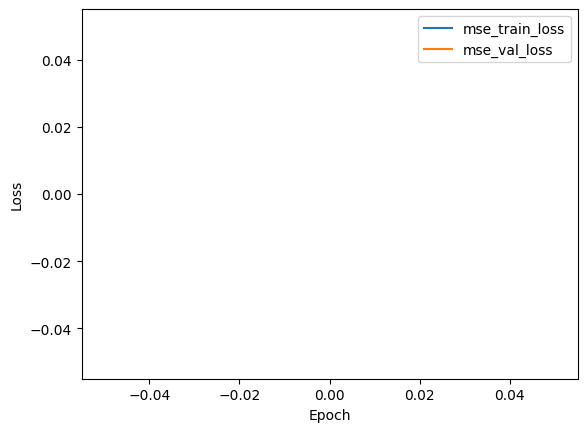

In [20]:
if train_save:
    lstm.plot_loss()

## Evaluate VAE-LSTM Model

In [ ]:
from Utils.models import VAE_LSTM

vae_lstm = VAE_LSTM(vae, lstm)
#vae_lstm.evaluate(test_loader, 0.9)

In [20]:
import numpy as np


threshold_list = np.linspace(0.1, 1, 37)
print(threshold_list)

[0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275 0.3   0.325 0.35  0.375
 0.4   0.425 0.45  0.475 0.5   0.525 0.55  0.575 0.6   0.625 0.65  0.675
 0.7   0.725 0.75  0.775 0.8   0.825 0.85  0.875 0.9   0.925 0.95  0.975
 1.   ]
